In [ ]:
# %%
# Import necessary libraries for data handling, model utilization, and visualization
import numpy as np
import pandas as pd
import yfinance as yf  # For collecting financial data
import matplotlib.pyplot as plt
from typing import List, Dict, Optional, Tuple
from datetime import datetime, timedelta
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from scipy.optimize import minimize
from collections import deque
# Import the custom Model class
from Model import Model
import logging
# Configure logging
logging.basicConfig(level=logging.INFO, format='%(levelname)s:%(message)s')

# Set the random seed for reproducibility across numpy and tensorflow
np.random.seed(123)
tf.random.set_seed(123)
# 
plt.style.use('Solarize_Light2')

# Define the tickers and date range with consideration of trading days
INITIAL_FOUR = ['AGG', 'DBC', 'VTI', '^VIX']#, 'VEA', 'EEM', 'VNQ', 'IWM']
LARGE_CAP = ['AAPL', 'MSFT', 'GOOGL', 'AMZN']
REITS = ['O', 'AMT', 'SPG', 'PLD', 'VTR']
BONDS = ['JNK', 'LQD', 'BND', 'BSV']
SMALL_CAP = ['CELH', 'PETS', 'FOLD', 'INSG']

# Set tickers to test
TICKERS = SMALL_CAP

# Approximate number of trading days per year (useful for annualizing returns)
TRADING_DAYS_PER_YEAR = 252
# Define transaction cost rate
C = 0.0001  # 0.01%

DAILY = 1
WEEKLY = 5
MONTHLY = 20

REBALANCING_FREQUENCY = WEEKLY

# Confirm setup
print("Setup complete: libraries imported, random seed set, and tickers defined.")

Setup complete: libraries imported, random seed set, and tickers defined.


In [5]:
# %%
# Data Collection Step
# Objective: Fetch historical adjusted close prices for defined tickers and date range

# Download data using yfinance for the specified tickers and date range
def get_data(tickers, start_date, end_date):
    """
    Retrieves historical adjusted close prices for the given tickers and date range.
    
    Parameters:
    - tickers: List of stock ticker symbols
    - start_date: Start date for historical data
    - end_date: End date for historical data
    
    Returns:
    - DataFrame of adjusted close prices, with each column representing a ticker
    """
    # Fetch asset prices
    asset_data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
    asset_data.dropna(inplace=True)

    # Fetch risk-free rate (^IRX) which represents the 13-week Treasury Bill
    rf_ticker = '^IRX'
    rf_data = yf.download(rf_ticker, start=start_date, end=end_date)['Adj Close']
    rf_data = rf_data.resample('D').ffill()  # Forward-fill to get daily rates
    rf_data = rf_data / 100 / TRADING_DAYS_PER_YEAR  # Convert annual percentage to daily decimal

    # Combine asset data and risk-free rates
    data = asset_data.join(rf_data.rename(columns={'^IRX':'Risk_Free_Rate_Daily'}), how='left')
    data['Risk_Free_Rate_Daily'].fillna(method='ffill', inplace=True)

    return data

# Fetch the data and display a quick preview
data = get_data(TICKERS, '2006-01-01', '2024-11-26')
print("Data fetched successfully. Sample data:")
print(data.head())

# Confirm data spans the expected range and has the expected number of columns
print(f"Data covers {len(data)} trading days with {len(data.columns)} assets.")

[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  1 of 1 completed

Data fetched successfully. Sample data:
Ticker          CELH   FOLD        INSG      PETS  Risk_Free_Rate_Daily
Date                                                                   
2007-05-31  6.066667  14.43  232.300003  7.027075              0.000182
2007-06-01  6.000000  13.50  235.199997  7.081507              0.000185
2007-06-04  5.800000  13.80  236.600006  7.037961              0.000184
2007-06-05  5.666667  14.02  250.399994  7.070618              0.000186
2007-06-06  6.000000  14.00  244.300003  7.086947              0.000185
Data covers 4404 trading days with 5 assets.



/var/folders/60/5d3h4l453h9ccqs1c1vsm1qr0000gn/T/ipykernel_9871/59758846.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Risk_Free_Rate_Daily'].fillna(method='ffill', inplace=True)
/var/folders/60/5d3h4l453h9ccqs1c1vsm1qr0000gn/T/ipykernel_9871/59758846.py:30: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['Risk_Free_Rate_Daily'].fillna(method='ffill', inplace=True)


In [6]:
# %%
def preprocess_data(data, rolling_window=50):
    """
    Prepares data by calculating window-day rolling averages and returns.

    Parameters:
    - data: DataFrame of historical adjusted close prices for assets
    - rolling_window: Window size for the rolling average

    Returns:
    - normalized_data: Smoothed prices, normalized to start at 1 for each asset
    - returns: Smoothed returns using a rolling mean of percentage changes
    """
    # Calculate rolling mean for prices and returns to smooth the data
    smoothed_prices = (data.rolling(window=rolling_window).mean()).dropna()
    smoothed_returns = (data.pct_change().rolling(window=rolling_window).mean()).dropna()
    # Normalize prices to start each asset's time series at 1
    normalized_data = smoothed_prices / smoothed_prices.iloc[0]
    
    return normalized_data, smoothed_returns


# Run preprocessing and display sample data
normalized_data, smoothed_returns = preprocess_data(data)
print("Data preprocessing complete. Sample normalized data:")
print(normalized_data.head())
print("\nSample daily returns:")
print(smoothed_returns.head())


Data preprocessing complete. Sample normalized data:
Ticker          CELH      FOLD      INSG      PETS  Risk_Free_Rate_Daily
Date                                                                    
2007-08-09  1.000000  1.000000  1.000000  1.000000              1.000000
2007-08-10  0.997943  0.996299  0.999305  1.002515              0.999256
2007-08-13  0.995699  0.994079  0.998288  1.004720              0.998724
2007-08-14  0.993267  0.990716  0.996616  1.006603              0.998192
2007-08-15  0.991771  0.986677  0.993475  1.008044              0.995810

Sample daily returns:
Ticker          CELH      FOLD      INSG      PETS  Risk_Free_Rate_Daily
Date                                                                    
2007-08-10  0.000921 -0.002977 -0.000174  0.002696             -0.000685
2007-08-13  0.000640 -0.001705 -0.000522  0.002391             -0.000447
2007-08-14  0.000282 -0.002826 -0.001243  0.002100             -0.000451
2007-08-15  0.001552 -0.003486 -0.002817  0.0016

In [7]:
class Portfolio:
    def __init__(self, initial_cash: float, asset_names: List[str], transaction_cost: float = 0.0001):
        self.initial_cash = initial_cash
        self.current_value = initial_cash
        self.transaction_cost_rate = transaction_cost
        self.asset_names = asset_names
        self.current_weights = np.zeros(len(asset_names))
        self.portfolio_values = []
        self.weights_history = []
        self.dates = []
        self.transaction_cost = 0.0  # Initialize transaction cost

    def rebalance(self, new_weights: np.array):
        # Compute transaction costs
        if len(self.weights_history) == 0:
            transaction_cost = self.transaction_cost_rate * np.sum(np.abs(new_weights))
        else:
            transaction_cost = self.transaction_cost_rate * np.sum(np.abs(new_weights - self.current_weights))
        self.transaction_cost = transaction_cost * self.current_value
        self.current_weights = new_weights.copy()
        self.weights_history.append(self.current_weights.copy())

    def update_portfolio_value(self, asset_returns: np.array, current_date: pd.Timestamp):
        # Compute portfolio return
        portfolio_return = np.dot(self.current_weights, asset_returns)
        self.current_value = self.current_value * (1 + portfolio_return) - self.transaction_cost
        self.transaction_cost = 0.0
        self.portfolio_values.append(self.current_value)
        self.dates.append(current_date)
    
    def get_portfolio_values(self):
        return self.portfolio_values


In [8]:
def calculate_metrics(portfolio_values, risk_free_rates):
    """
    Calculates performance metrics for the portfolio, incorporating historical risk-free rates.

    Parameters:
    - portfolio_values: List of daily portfolio values over the testing period.
    - risk_free_rates: Array of daily risk-free rates corresponding to portfolio_returns.

    Returns:
    - metrics: Dictionary containing various performance metrics.
    """
    # Drop risk free rate from portfolio values
    portfolio_values = portfolio_values[:-1]
    # Convert portfolio values to daily returns
    portfolio_returns = np.diff(portfolio_values) / portfolio_values[:-1]
    
    # Ensure risk_free_rates aligns with portfolio_returns
    risk_free_rates = risk_free_rates[:len(portfolio_returns)]
    
    # Compute excess returns
    excess_returns = portfolio_returns - risk_free_rates

    # Number of days
    N = len(portfolio_returns)

    # Calculate Sharpe Ratio using excess returns
    mean_excess_return = np.mean(excess_returns)
    std_dev = np.std(portfolio_returns)  # Use actual returns for std dev
    sharpe_ratio = mean_excess_return / std_dev * np.sqrt(TRADING_DAYS_PER_YEAR)

    # Calculate Sortino Ratio
    downside_returns = excess_returns[excess_returns < 0]
    downside_std_dev = np.std(downside_returns) if len(downside_returns) > 0 else 0
    sortino_ratio = (mean_excess_return / downside_std_dev) * np.sqrt(TRADING_DAYS_PER_YEAR) if downside_std_dev != 0 else np.nan

    # Calculate Maximum Drawdown
    cumulative_max = np.maximum.accumulate(portfolio_values[:len(portfolio_returns)])
    drawdowns = (cumulative_max - portfolio_values[:len(cumulative_max)]) / cumulative_max
    max_drawdown = np.max(drawdowns)

    # Expected return (annualized)
    cumulative_return = (portfolio_values[-1] / portfolio_values[0])
    annualized_return = (cumulative_return) ** (TRADING_DAYS_PER_YEAR / N) - 1
    print(f"cumulative_return: {cumulative_return}, annualized_return: {annualized_return}")

    # Standard deviation of returns (annualized)
    annualized_std = std_dev * np.sqrt(TRADING_DAYS_PER_YEAR)

    # Percentage of positive returns
    positive_returns = portfolio_returns[portfolio_returns > 0]
    percentage_positive = len(positive_returns) / len(portfolio_returns) * 100

    # Average profit / average loss (profit/loss ratio)
    average_profit = np.mean(portfolio_returns[portfolio_returns > 0]) if len(positive_returns) > 0 else 0
    average_loss = np.mean(portfolio_returns[portfolio_returns < 0]) if len(portfolio_returns[portfolio_returns < 0]) > 0 else 0
    profit_loss_ratio = (average_profit / -average_loss) if average_loss != 0 else np.nan

    metrics = {
        "Annualized Return": annualized_return,
        "Annualized Std Dev": annualized_std,
        "Sharpe Ratio": sharpe_ratio,
        "Sortino Ratio": sortino_ratio,
        "Max Drawdown": max_drawdown,
        "% Positive Returns": percentage_positive,
        "Profit/Loss Ratio": profit_loss_ratio
    }
    
    return metrics


In [9]:
# %%
def equal_weighted_strategy(returns):
    """
    Creates an equal-weighted portfolio.

    Parameters:
    - returns: DataFrame of daily returns for each asset.

    Returns:
    - equal_weights: Numpy array of equal weights for each asset.
    """
    num_assets = returns.shape[1]
    equal_weights = np.ones(num_assets) / num_assets
    return equal_weights

# Define function to get MV weights
def mean_variance_optimized_strategy(returns, expected_rf, expected_returns=None):
    """
    Creates a mean-variance optimized portfolio by maximizing the Sharpe Ratio.

    Parameters:
    - returns: DataFrame of daily returns for each asset.
    - expected_rf: Expected risk-free rate (scalar)
    - expected_returns: Numpy array of expected returns (if provided, use this instead of historical mean returns)

    Returns:
    - optimized_weights: Numpy array of optimized weights for each asset.
    """
    if expected_returns is None:
        mean_returns = returns.mean() - expected_rf
    else:
        mean_returns = expected_returns - expected_rf  # Expected returns minus risk-free rate
    cov_matrix = returns.cov()

    def neg_sharpe(weights):
        portfolio_return = np.dot(weights, mean_returns)
        portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        return -portfolio_return / portfolio_std

    # Constraints: Weights must sum to 1, and each weight must be between 0 and 1
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(returns.shape[1]))

    result = minimize(neg_sharpe, np.ones(returns.shape[1]) / returns.shape[1], bounds=bounds, constraints=constraints)
    optimized_weights = result.x
    optimized_weights = np.maximum(optimized_weights, 0)  # Avoid negative weights
    return optimized_weights

# Define function to get MD weights
def maximum_diversification(returns):
    """
    Perform maximum diversification optimization based on the given returns.

    Parameters:
    - returns: DataFrame of daily returns for each asset.

    Returns:
    - optimal_weights: Array of portfolio weights that maximize diversification.
    """
    # Calculate asset volatilities (standard deviation of each asset’s returns)
    asset_volatilities = returns.std()

    # Calculate the covariance matrix of returns
    cov_matrix = returns.cov()

    # Define the diversification ratio to be maximized
    def neg_diversification_ratio(weights):
        # Calculate the weighted average asset volatility
        weighted_volatility = np.dot(weights, asset_volatilities)
        
        # Calculate the portfolio volatility as the weighted covariance matrix
        portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        
        # Diversification ratio (we negate this because we want to maximize it)
        diversification_ratio = weighted_volatility / portfolio_volatility
        return -diversification_ratio  # Negate to turn this into a minimization problem

    # Constraints: weights sum to 1, and each weight between 0 and 1 (long-only portfolio)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(len(asset_volatilities)))

    # Initial guess (equal allocation)
    init_guess = np.ones(len(asset_volatilities)) / len(asset_volatilities)

    # Optimize to find weights that maximize diversification ratio
    result = minimize(neg_diversification_ratio, init_guess, bounds=bounds, constraints=constraints)
    optimal_weights = result.x
    
    return optimal_weights


In [10]:
def average_metrics(metrics_list):
    """
    Calculates the average of each metric in the list of metrics.
    """
    avg_metrics = {}
    keys = metrics_list[0].keys()
    for key in keys:
        avg_metrics[key] = np.mean([m[key] for m in metrics_list])
    return avg_metrics


In [11]:
def plot_performance_comparison(portfolio_histories, periods, strategies):
    """
    Plots the actual portfolio values for each strategy across all testing periods in a grid format,
    swapping rows and columns such that rows represent strategies and columns represent periods.
    
    Parameters:
    - portfolio_histories: Dictionary containing portfolio value histories for each strategy.
    - periods: List of tuples containing (training_end, testing_start, testing_end) for each period.
    - strategies: List of strategy names to plot.
    """
    num_periods = len(periods)
    num_strategies = len(strategies)
    
    # Set up the matplotlib figure
    fig, axes = plt.subplots(num_strategies, num_periods, figsize=(5*num_periods, 3*num_strategies), sharex=False, sharey=False)
    fig.suptitle('Portfolio Performance Comparison (Raw Values)', fontsize=16, y=0.92)
    
    for strat_idx, strategy in enumerate(strategies):
        for period_idx, period in enumerate(periods):
            training_end, testing_start, testing_end = period
            
            # Handle axes indexing for single row or column
            if num_periods == 1 and num_strategies == 1:
                ax = axes
            elif num_periods == 1:
                ax = axes[strat_idx]
            elif num_strategies == 1:
                ax = axes[period_idx]
            else:
                ax = axes[strat_idx, period_idx]
            
            # Get the corresponding portfolio history
            history = portfolio_histories[strategy][period_idx]
            dates = history['dates']
            values = history['values']
            # Plot raw portfolio values
            ax.plot(dates, values, label=f"{strategy}")
            ax.set_title(f"{strategy} | {testing_start} to {testing_end}")
            ax.set_xlabel('Date')
            ax.set_ylabel('Portfolio Value ($)')
            ax.legend()
            ax.grid(True)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


In [12]:
def plot_weights_comparison(portfolio_histories, periods, strategies, asset_names):
    """
    Plots the portfolio weights for each strategy across all testing periods in a grid format,
    with each asset having its own line on the graph, colored differently and with a legend.

    Parameters:
    - portfolio_histories: Dictionary containing portfolio histories for each strategy.
      Each entry should have 'dates', 'values', and 'weights'.
    - periods: List of tuples containing (training_end, testing_start, testing_end) for each period.
    - strategies: List of strategy names to plot.
    - asset_names: List of asset names corresponding to portfolio weights.
    """
    num_periods = len(periods)
    num_strategies = len(strategies)
    
    # Set up the matplotlib figure
    fig, axes = plt.subplots(num_strategies, num_periods, figsize=(5*num_periods, 3*num_strategies), sharex=False, sharey=False)
    fig.suptitle('Portfolio Weights Comparison', fontsize=16, y=0.92)
    
    # If there's only one strategy or one period, adjust axes accordingly
    if num_strategies == 1 and num_periods == 1:
        axes = np.array([[axes]])
    elif num_strategies == 1:
        axes = np.expand_dims(axes, axis=0)
    elif num_periods == 1:
        axes = np.expand_dims(axes, axis=1)
    
    for strat_idx, strategy in enumerate(strategies):
        for period_idx, period in enumerate(periods):
            training_end, testing_start, testing_end = period
            
            ax = axes[strat_idx, period_idx]
            
            # Get the corresponding portfolio history
            history = portfolio_histories[strategy][period_idx]
            dates = history['dates']
            weights = np.array(history['weights'])  # Shape: (num_days, num_assets)
            
            # Create a DataFrame for easier plotting
            weights_df = pd.DataFrame(weights, index=dates, columns=asset_names)
            
            # Plot each asset's weight over time
            for asset in asset_names:
                ax.plot(weights_df.index, weights_df[asset], label=asset)
            
            ax.set_title(f"{strategy} | {testing_start} to {testing_end}")
            ax.set_xlabel('Date')
            ax.set_ylabel('Weight')
            ax.legend(fontsize='small', ncol=2)
            ax.grid(True)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


In [13]:
# %%
# Define testing periods
training_end_dates = ['2010-12-31', '2012-12-31', '2014-12-31', '2016-12-31', '2018-12-31','2020-12-31','2022-12-31']
testing_start_dates = ['2011-01-01', '2013-01-01', '2015-01-01', '2017-01-01', '2019-01-01' ,'2021-01-01','2023-01-01']
testing_end_dates = ['2012-12-31', '2014-12-31', '2016-12-31', '2018-12-31', '2020-12-31','2022-12-31','2024-11-25']

periods = list(zip(training_end_dates, testing_start_dates, testing_end_dates))

# Initialize lists to store performance metrics for each model
lstm_metrics = []
mvo_metrics = []
md_metrics = []
ew_metrics = []
# Initialize a dictionary to store portfolio histories for each strategy
portfolio_histories = {
    'LSTM': [],
    'MVO': [],
    'MD': [],
    'EW': [],
}

initial_cash = 100000

In [14]:
def run_backtest(data, periods, initial_cash, C, rebalancing_frequency=REBALANCING_FREQUENCY, lstm_window_size=50, mvo_md_window_size=50):
    portfolio_histories = {
        'LSTM': [],
        'MVO': [],
        'MD': [],
        'EW': [],
    }
    lstm_metrics = []
    mvo_metrics = []
    md_metrics = []
    ew_metrics = []
    for period in periods:
        training_end, testing_start, testing_end = period
        print(f"\nProcessing period: Training up to {training_end}, Testing from {testing_start} to {testing_end}")

        # Split the data into training and testing sets
        training_data = data.loc[:training_end].copy()
        testing_data = data.loc[testing_start:testing_end].copy()
        testing_returns = testing_data.pct_change().fillna(0)
        testing_returns = testing_returns.drop('Risk_Free_Rate_Daily', axis=1)
        # Ensure there is enough data for testing
        if len(testing_data) < 1:
            print("Not enough data for testing period")
            continue

        # -------------------------------------------
        # LSTM Model
        # -------------------------------------------

        # Train the LSTM model
        lstm_model = Model()
        lstm_model.train(training_data)

        # Initialize the portfolio for LSTM strategy
        portfolio_lstm = Portfolio(
            initial_cash,
            asset_names=testing_returns.columns.tolist(),
            transaction_cost=C
        )

        # Combine the last 'lstm_window_size' days of training data with the testing data
        combined_data = pd.concat(
            [training_data.tail(lstm_window_size), testing_data],
            ignore_index=False
        )

        # Calculate daily returns
        returns = combined_data.drop('Risk_Free_Rate_Daily', axis=1).pct_change().fillna(0)

        # Ensure 'Risk_Free_Rate_Daily' is present in combined_data
        if 'Risk_Free_Rate_Daily' not in combined_data.columns:
            # Fetch risk-free rate data
            rf_data = data.loc[combined_data.index, 'Risk_Free_Rate_Daily']
            combined_data = combined_data.join(rf_data.rename('Risk_Free_Rate_Daily'))

        # Create combined_data similar to training
        combined_data = pd.concat([combined_data, returns], axis=1)

        # Assign correct column names
        combined_data.columns = [f"{ticker}_price" for ticker in testing_returns.columns] + \
                                [f"{ticker}_return" for ticker in testing_returns.columns] + \
                                ['Risk_Free_Rate_Daily']
        
        last_rebalance_day = -rebalancing_frequency  # Ensure the first day is a rebalance

        # Now, in the loop, we can get input_sequence directly
        for idx, current_date in enumerate(testing_data.index):
            # Calculate the end index for the input sequence in combined_data
            end_idx = lstm_window_size + idx  # idx starts from 0

            # Check if it's time to rebalance
            if (idx - last_rebalance_day) >= rebalancing_frequency or idx == 0:
                # Extract the input sequence: the preceding 'lstm_window_size' days
                input_sequence = combined_data.iloc[end_idx - lstm_window_size:end_idx].values

                # Predict the allocation using the LSTM model
                allocation = lstm_model.predict_allocation(input_sequence)

                # Rebalance the portfolio with the new allocation
                portfolio_lstm.rebalance(allocation)

                last_rebalance_day = idx  # Update last rebalance day
            else:
                portfolio_lstm.weights_history.append(portfolio_lstm.weights_history[-1])
            
            # Get today's return
            today_return = testing_returns.iloc[idx].values

            # Update the portfolio value based on today's return
            portfolio_lstm.update_portfolio_value(today_return, current_date)

        # Store the LSTM portfolio history
        portfolio_values_lstm = portfolio_lstm.get_portfolio_values()
        portfolio_dates_lstm = portfolio_lstm.dates
        portfolio_histories['LSTM'].append({
            'dates': portfolio_dates_lstm,
            'values': portfolio_values_lstm,
            'weights': portfolio_lstm.weights_history
        })

        # Calculate and store performance metrics for LSTM
        metrics_lstm = calculate_metrics(
            portfolio_values_lstm, 
            data.loc[testing_start:testing_end, 'Risk_Free_Rate_Daily'].values
        )
        lstm_metrics.append(metrics_lstm)

        # -------------------------------------------
        # Mean-Variance Optimization (MVO) Model
        # -------------------------------------------

        # Calculate full returns up to the end of the testing period
        returns_full_testing = data.loc[:testing_end].pct_change().dropna()
        returns_full_testing = returns_full_testing.drop('Risk_Free_Rate_Daily', axis=1)
        # Returns only for the testing period
        returns_testing = data.loc[testing_start:testing_end].pct_change().dropna()
        returns_testing = returns_testing.drop('Risk_Free_Rate_Daily', axis=1)
        # Get indices of testing dates in returns_full_testing
        testing_indices = returns_full_testing.index.get_indexer_for(returns_testing.index)

        # Initialize the portfolio for MVO strategy
        portfolio_mv = Portfolio(
            initial_cash,
            asset_names=testing_returns.columns.tolist(),
            transaction_cost=C
        )

        # Initialize a variable to track rebalancing schedule
        last_rebalance_day = -rebalancing_frequency  # Ensure the first day is a rebalance

        for idx, i in enumerate(testing_indices):
            # i is the index in returns_full_testing corresponding to the current testing day
            current_date = returns_testing.index[idx]

            # Check if it's time to rebalance
            if (idx - last_rebalance_day) >= rebalancing_frequency or idx == 0:
                # Ensure we have enough data for the window
                if i >= mvo_md_window_size - 1:
                    # Extract the past 'mvo_md_window_size' days of returns ending on current date
                    input_data = returns_full_testing.iloc[i - mvo_md_window_size + 1:i + 1]
                    # Extract corresponding risk-free rates
                    rf_data = data.loc[input_data.index, 'Risk_Free_Rate_Daily']
                    expected_rf = rf_data.mean()  # Calculate expected risk-free rate
                else:
                    # Not enough data, skip rebalancing
                    print(f"Not enough data for MVO window on {current_date}")
                    input_data = returns_full_testing.iloc[:i + 1]
                    rf_data = data.loc[input_data.index, 'Risk_Free_Rate_Daily']
                    expected_rf = rf_data.mean()  # Calculate expected risk-free rate

                weights_mv = mean_variance_optimized_strategy(input_data, expected_rf)  # Pass expected_rf

                # Rebalance the portfolio with MVO weights
                portfolio_mv.rebalance(weights_mv)

                last_rebalance_day = idx  # Update last rebalance day
            else:
                # Maintain previous weights
                portfolio_mv.weights_history.append(portfolio_mv.weights_history[-1])

            # Get today's return
            today_return = returns_testing.iloc[idx].values

            # Update portfolio value
            portfolio_mv.update_portfolio_value(today_return, current_date)

        # Store MVO portfolio history
        portfolio_values_mv = portfolio_mv.get_portfolio_values()
        portfolio_dates_mv = portfolio_mv.dates
        portfolio_histories['MVO'].append({
            'dates': portfolio_dates_mv,
            'values': portfolio_values_mv,
            'weights': portfolio_mv.weights_history
        })

        # Calculate and store performance metrics for MVO
        metrics_mv = calculate_metrics(
            portfolio_values_mv, 
            data.loc[testing_start:testing_end, 'Risk_Free_Rate_Daily'].values
        )
        mvo_metrics.append(metrics_mv)

        # -------------------------------------------
        # Maximum Diversification (MD) Model
        # -------------------------------------------

        # Initialize the portfolio for MD strategy
        portfolio_md = Portfolio(
            initial_cash,
            asset_names=testing_returns.columns.tolist(),
            transaction_cost=C
        )

        # Initialize a variable to track rebalancing schedule
        last_rebalance_day = -rebalancing_frequency  # Ensure the first day is a rebalance

        for idx, i in enumerate(testing_indices):
            # i is the index in returns_full_testing corresponding to the current testing day
            current_date = returns_testing.index[idx]

            # Check if it's time to rebalance
            if (idx - last_rebalance_day) >= rebalancing_frequency or idx == 0:
                # Ensure we have enough data for the window
                if i >= mvo_md_window_size - 1:
                    # Extract the past 'mvo_md_window_size' days of returns ending on current date
                    input_data = returns_full_testing.iloc[i - mvo_md_window_size + 1:i + 1]
                else:
                    # Not enough data, skip rebalancing
                    print(f"Not enough data for MD window on {current_date}")
                    input_data = returns_full_testing.iloc[:i + 1]

                weights_md = maximum_diversification(input_data)

                # Rebalance the portfolio with MD weights
                portfolio_md.rebalance(weights_md)

                last_rebalance_day = idx  # Update last rebalance day
            else:
                # Maintain previous weights
                portfolio_md.weights_history.append(portfolio_md.weights_history[-1])

            # Get today's return
            today_return = returns_testing.iloc[idx].values

            # Update portfolio value
            portfolio_md.update_portfolio_value(today_return, current_date)

        # Store MD portfolio history
        portfolio_values_md = portfolio_md.get_portfolio_values()
        portfolio_dates_md = portfolio_md.dates
        portfolio_histories['MD'].append({
            'dates': portfolio_dates_md,
            'values': portfolio_values_md,
            'weights': portfolio_md.weights_history
        })

        # Calculate and store performance metrics for MD
        metrics_md = calculate_metrics(
            portfolio_values_md, 
            data.loc[testing_start:testing_end, 'Risk_Free_Rate_Daily'].values
        )
        md_metrics.append(metrics_md)

        # -------------------------------------------
        # Equal Weighted (EW) Strategy
        # -------------------------------------------

        # Initialize the portfolio for EW strategy
        portfolio_ew = Portfolio(
            initial_cash,
            asset_names=testing_returns.columns.tolist(),
            transaction_cost=C
        )

        weights_ew = equal_weighted_strategy(returns_full_testing)

        for idx in range(len(testing_returns)):
            today_return = testing_returns.iloc[idx].values
            current_date = testing_returns.index[idx]
            if idx % 252 == 0:
                # Rebalance yearly
                portfolio_ew.rebalance(weights_ew)
            else:
                # Maintain previous weights
                portfolio_ew.weights_history.append(portfolio_ew.weights_history[-1])
            # print(f"EW weights: {weights_ew}", f"EW portfolio value: {portfolio_ew.current_value}")
            portfolio_ew.update_portfolio_value(today_return, current_date)

        # Store EW portfolio history
        portfolio_values_ew = portfolio_ew.get_portfolio_values()
        portfolio_dates_ew = portfolio_ew.dates
        portfolio_histories['EW'].append({
            'dates': portfolio_dates_ew,
            'values': portfolio_values_ew,
            'weights': portfolio_ew.weights_history
        })

        # Calculate and store performance metrics for EW
        metrics_ew = calculate_metrics(
            portfolio_values_ew, 
            data.loc[testing_start:testing_end, 'Risk_Free_Rate_Daily'].values
        )
        ew_metrics.append(metrics_ew)

    # Return the portfolio histories and metrics
    return portfolio_histories, lstm_metrics, mvo_metrics, md_metrics, ew_metrics


In [15]:
# Run the backtest with 4 ETF tickers, rebalancing frequency 1
portfolio_histories, lstm_metrics, mvo_metrics, md_metrics, ew_metrics = run_backtest(
    data,
    periods,
    initial_cash,
    C,
    rebalancing_frequency=REBALANCING_FREQUENCY,
    lstm_window_size=50,
    mvo_md_window_size=50,
)


Processing period: Training up to 2010-12-31, Testing from 2011-01-01 to 2012-12-31
Epoch 1/100


/Users/aryika/anaconda3/envs/py396/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0242
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0047
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.7859e-04
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.0081
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.0118    
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.0192
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0012
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0034
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: -0.0032
Epoch 10/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: -0.0118
Epoch 11/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: -0.0156
Epoch 12/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: -0.0258
Epoch 13/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: -0.0170
Epoch 14/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: -0.0231
Epoch 15/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

/Users/aryika/anaconda3/envs/py396/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0188
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0059
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0028
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.0874e-04
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.0025   
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.0053
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.0076  
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.0099
Epoch 9/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.0125
Epoch 10/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: -0.0151
Epoch 11/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.0179
Epoch 12/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.0208
Epoch 13/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.0239
Epoch 14/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: -0.0264
Epoch 15/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/st

/Users/aryika/anaconda3/envs/py396/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: -0.0457
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.0560
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.0584
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.0604
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.0617
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.0626
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.0635
Epoch 8/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.0627
Epoch 9/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.0635
Epoch 10/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: -0.0655
Epoch 11/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.0696
Epoch 12/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.0706
Epoch 13/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.0760
Epoch 14/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.0709
Epoch 15/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - 

/Users/aryika/anaconda3/envs/py396/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: -0.0658
Epoch 2/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.0863
Epoch 3/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.0934
Epoch 4/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.0904
Epoch 5/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.1009
Epoch 6/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.1031
Epoch 7/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.0998
Epoch 8/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.1097
Epoch 9/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.1106
Epoch 10/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.1123
Epoch 11/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: -0.1130
Epoch 12/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.1156
Epoch 13/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.1216
Epoch 14/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.1239
Epoch 15/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - 

/Users/aryika/anaconda3/envs/py396/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: -0.0312
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: -0.0412
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: -0.0400
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: -0.0416
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: -0.0468
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: -0.0496
Epoch 7/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: -0.0531
Epoch 8/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: -0.0582
Epoch 9/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: -0.0588
Epoch 10/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: -0.0617
Epoch 11/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: -0.0647
Epoch 12/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: -0.0708
Epoch 13/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: -0.0740
Epoch 14/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: -0.0812
Epoch 15/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - 

/Users/aryika/anaconda3/envs/py396/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: -0.0165
Epoch 2/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: -0.0310
Epoch 3/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: -0.0345
Epoch 4/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: -0.0414
Epoch 5/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: -0.0448
Epoch 6/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: -0.0493
Epoch 7/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: -0.0541
Epoch 8/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: -0.0581
Epoch 9/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: -0.0653
Epoch 10/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: -0.0692
Epoch 11/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: -0.0639
Epoch 12/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: -0.0739
Epoch 13/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: -0.0761
Epoch 14/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: -0.0778
Epoch 15/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - 

/Users/aryika/anaconda3/envs/py396/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: -0.0520
Epoch 2/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: -0.0621
Epoch 3/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: -0.0625
Epoch 4/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: -0.0651
Epoch 5/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: -0.0658
Epoch 6/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: -0.0685
Epoch 7/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: -0.0704
Epoch 8/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: -0.0757
Epoch 9/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: -0.0774
Epoch 10/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: -0.0787
Epoch 11/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: -0.0830
Epoch 12/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: -0.0872
Epoch 13/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: -0.0846
Epoch 14/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: -0.0903
Epoch 15/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - 

In [16]:
# Calculate average metrics for each model
lstm_avg_metrics = average_metrics(lstm_metrics)
mvo_avg_metrics = average_metrics(mvo_metrics)
md_avg_metrics = average_metrics(md_metrics)
ew_avg_metrics = average_metrics(ew_metrics)

In [17]:
# Print the average metrics
print("\nAverage Metrics for LSTM Model:")
for key, value in lstm_avg_metrics.items():
    print(f"{key}: {value:.4f}")

print("\nAverage Metrics for MVO Strategy:")
for key, value in mvo_avg_metrics.items():
    print(f"{key}: {value:.4f}")

print("\nAverage Metrics for MD Strategy:")
for key, value in md_avg_metrics.items():
    print(f"{key}: {value:.4f}")

print("\nAverage Metrics for Equal Weighted Strategy:")
for key, value in average_metrics(ew_metrics).items():
    print(f"{key}: {value:.4f}")



Average Metrics for LSTM Model:
Annualized Return: 0.2382
Annualized Std Dev: 0.5468
Sharpe Ratio: 0.5191
Sortino Ratio: 0.8075
Max Drawdown: 0.5078
% Positive Returns: 50.0654
Profit/Loss Ratio: 1.1037

Average Metrics for MVO Strategy:
Annualized Return: 0.6509
Annualized Std Dev: 0.7210
Sharpe Ratio: 1.1185
Sortino Ratio: 1.7735
Max Drawdown: 0.4638
% Positive Returns: 51.2727
Profit/Loss Ratio: 1.1486

Average Metrics for MD Strategy:
Annualized Return: 0.2739
Annualized Std Dev: 0.3701
Sharpe Ratio: 0.7373
Sortino Ratio: 1.1737
Max Drawdown: 0.3584
% Positive Returns: 50.7266
Profit/Loss Ratio: 1.1111

Average Metrics for Equal Weighted Strategy:
Annualized Return: 0.4053
Annualized Std Dev: 0.4510
Sharpe Ratio: 0.8580
Sortino Ratio: 1.4064
Max Drawdown: 0.3847
% Positive Returns: 50.9146
Profit/Loss Ratio: 1.1267


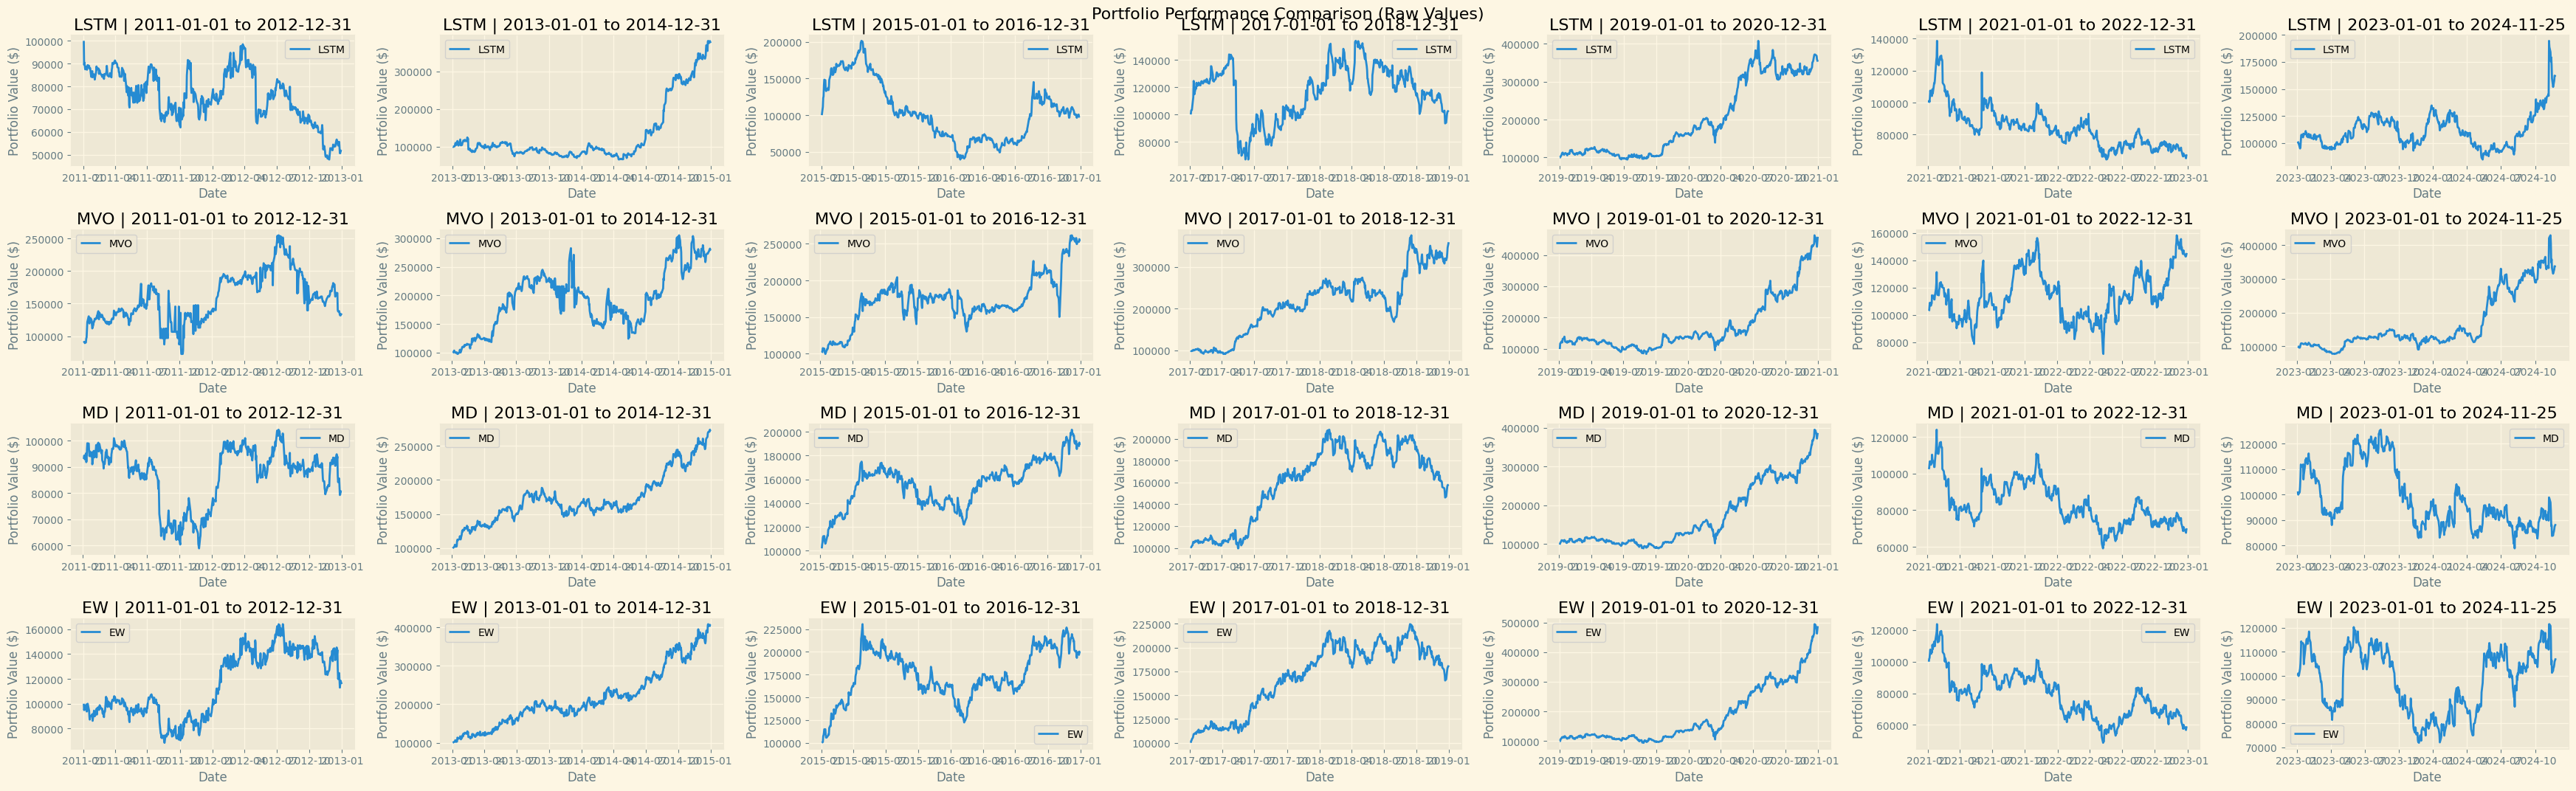

Period 1
LSTM Metrics:
Annualized Return: -0.2819
Annualized Std Dev: 0.5643
Sharpe Ratio: -0.3018
Sortino Ratio: -0.4165
Max Drawdown: 0.5209
% Positive Returns: 46.6000
Profit/Loss Ratio: 1.0863
MVO Metrics:
Annualized Return: 0.2127
Annualized Std Dev: 1.3740
Sharpe Ratio: 0.8106
Sortino Ratio: 1.1149
Max Drawdown: 0.5982
% Positive Returns: 46.4930
Profit/Loss Ratio: 1.1984
MD Metrics:
Annualized Return: -0.0694
Annualized Std Dev: 0.4209
Sharpe Ratio: 0.0379
Sortino Ratio: 0.0558
Max Drawdown: 0.4164
% Positive Returns: 49.4990
Profit/Loss Ratio: 1.0272
EW Metrics:
Annualized Return: 0.0893
Annualized Std Dev: 0.6345
Sharpe Ratio: 0.4480
Sortino Ratio: 0.7372
Max Drawdown: 0.3624
% Positive Returns: 50.2000
Profit/Loss Ratio: 1.0718


Period 2
LSTM Metrics:
Annualized Return: 0.9467
Annualized Std Dev: 0.6150
Sharpe Ratio: 1.3901
Sortino Ratio: 2.0743
Max Drawdown: 0.4691
% Positive Returns: 52.9880
Profit/Loss Ratio: 1.1491
MVO Metrics:
Annualized Return: 0.6782
Annualized Std De

In [18]:
strategies = ['LSTM','MVO', 'MD', 'EW']
plot_performance_comparison(portfolio_histories, periods, strategies)
for i in range(len(mvo_metrics)):
    print(f"Period {i+1}")
    print("LSTM Metrics:")
    for key, value in lstm_metrics[i].items():
        print(f"{key}: {value:.4f}")
    print("MVO Metrics:")
    for key, value in mvo_metrics[i].items():
        print(f"{key}: {value:.4f}")
    print("MD Metrics:")
    for key, value in md_metrics[i].items():
        print(f"{key}: {value:.4f}")
    print("EW Metrics:")
    for key, value in ew_metrics[i].items():
        print(f"{key}: {value:.4f}")
    print("\n")

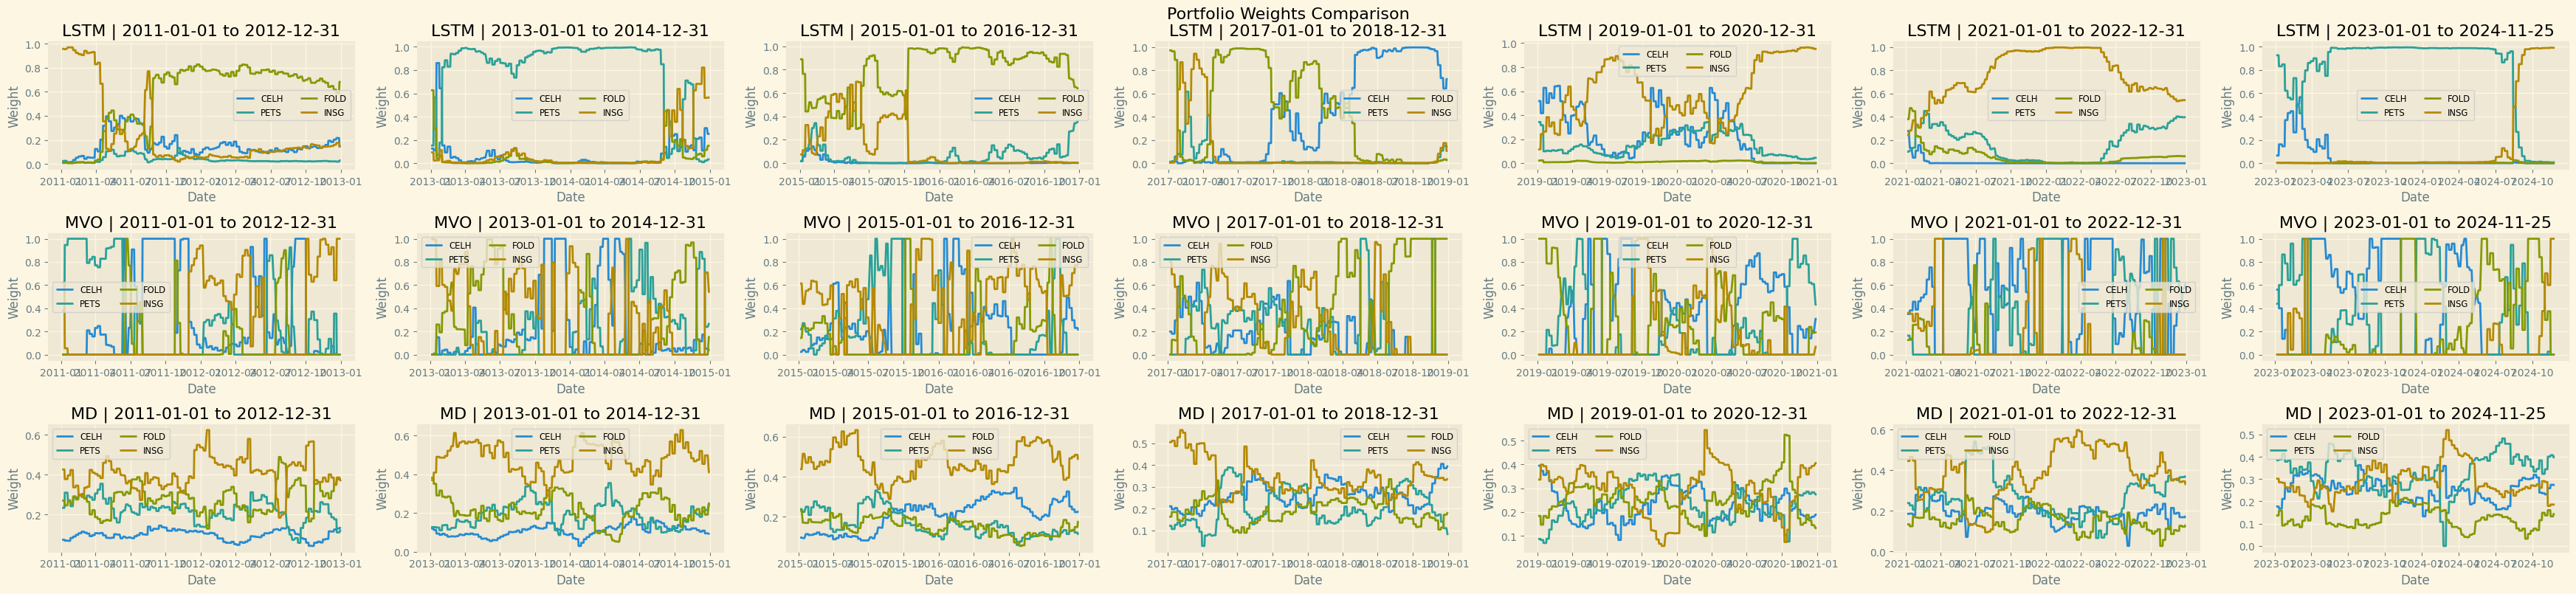

In [19]:
strategies = ['LSTM','MVO', 'MD']
asset_names = TICKERS
plot_weights_comparison(portfolio_histories, periods, strategies, asset_names)

In [20]:
TICKERS = ['AAPL','AMZN','NFLX','GOOG']
data = get_data(TICKERS, '2006-01-01', '2024-11-26')
portfolio_histories, lstm_metrics, mvo_metrics, md_metrics, ew_metrics = run_backtest(
    data,
    periods,
    initial_cash,
    C,
    rebalancing_frequency=1,
    lstm_window_size=50,
    mvo_md_window_size=50,
)

[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  1 of 1 completed


Processing period: Training up to 2010-12-31, Testing from 2011-01-01 to 2012-12-31
Epoch 1/100



/var/folders/60/5d3h4l453h9ccqs1c1vsm1qr0000gn/T/ipykernel_9871/59758846.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Risk_Free_Rate_Daily'].fillna(method='ffill', inplace=True)
/var/folders/60/5d3h4l453h9ccqs1c1vsm1qr0000gn/T/ipykernel_9871/59758846.py:30: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['Risk_Free_Rate_Daily'].fillna(method='ffill', inplace=True)
/Users/aryika/anaconda3/envs/py396/lib/python3.9/site-pack

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: -0.0839
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.0971
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.1001
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.1017
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.1030
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.1047
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.1067
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.1095
Epoch 9/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: -0.1129
Epoch 10/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: -0.1171
Epoch 11/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: -0.1174
Epoch 12/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: -0.1231
Epoch 13/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: -0.1086
Epoch 14/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: -0.1271
Epoch 15/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - 

/Users/aryika/anaconda3/envs/py396/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: -0.0370
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.0573
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.0614
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.0640
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.0663
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.0676
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: -0.0694
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.0702
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.0707
Epoch 10/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.0725
Epoch 11/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.0711
Epoch 12/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.0737
Epoch 13/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.0756
Epoch 14/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.0755
Epoch 15/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - 

/Users/aryika/anaconda3/envs/py396/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: -0.0731
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.0946
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.0965
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.0994
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: -0.1011
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.1053
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.1020
Epoch 8/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.1012
Epoch 9/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.1008
Epoch 10/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: -0.1008
Epoch 11/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.1037
Epoch 12/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.1031
Epoch 13/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.1064
Epoch 14/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.0972
Epoch 15/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - 

/Users/aryika/anaconda3/envs/py396/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: -0.0639
Epoch 2/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: -0.0751
Epoch 3/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: -0.0783
Epoch 4/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: -0.0792
Epoch 5/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: -0.0816
Epoch 6/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: -0.0826
Epoch 7/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: -0.0856
Epoch 8/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: -0.0838
Epoch 9/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: -0.0817
Epoch 10/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: -0.0834
Epoch 11/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: -0.0865
Epoch 12/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: -0.0895
Epoch 13/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: -0.0845
Epoch 14/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: -0.0879
Epoch 15/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - 

/Users/aryika/anaconda3/envs/py396/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: -0.0914
Epoch 2/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: -0.1013
Epoch 3/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: -0.0960
Epoch 4/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: -0.0979
Epoch 5/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: -0.0962
Epoch 6/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: -0.0978
Epoch 7/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: -0.0970
Epoch 8/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: -0.0971
Epoch 9/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: -0.0975
Epoch 10/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: -0.0985
Epoch 11/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: -0.0999
Epoch 12/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: -0.1020
Epoch 13/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: -0.0972
Epoch 14/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: -0.1024
Epoch 15/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - 

/Users/aryika/anaconda3/envs/py396/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: -0.0643
Epoch 2/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: -0.0766
Epoch 3/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: -0.0828
Epoch 4/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: -0.0859
Epoch 5/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: -0.0879
Epoch 6/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: -0.0907
Epoch 7/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: -0.0908
Epoch 8/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: -0.0915
Epoch 9/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: -0.0917
Epoch 10/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: -0.0887
Epoch 11/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: -0.0905
Epoch 12/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: -0.0935
Epoch 13/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: -0.0948
Epoch 14/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: -0.0950
Epoch 15/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - 

/Users/aryika/anaconda3/envs/py396/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: -0.0530
Epoch 2/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: -0.0637
Epoch 3/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: -0.0651
Epoch 4/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: -0.0647
Epoch 5/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: -0.0633
Epoch 6/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: -0.0562
Epoch 7/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: -0.0523
Epoch 8/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: -0.0562
Epoch 9/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: -0.0630
Epoch 10/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: -0.0603
Epoch 11/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: -0.0578
Epoch 12/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: -0.0647
Epoch 13/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: -0.0667
Epoch 14/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: -0.0657
Epoch 15/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - 

In [21]:
# Calculate average metrics for each model
lstm_avg_metrics = average_metrics(lstm_metrics)
mvo_avg_metrics = average_metrics(mvo_metrics)
md_avg_metrics = average_metrics(md_metrics)
ew_avg_metrics = average_metrics(ew_metrics)
# Print the average metrics
print("\nAverage Metrics for LSTM Model:")
for key, value in lstm_avg_metrics.items():
    print(f"{key}: {value:.4f}")

print("\nAverage Metrics for MVO Strategy:")
for key, value in mvo_avg_metrics.items():
    print(f"{key}: {value:.4f}")

print("\nAverage Metrics for MD Strategy:")
for key, value in md_avg_metrics.items():
    print(f"{key}: {value:.4f}")

print("\nAverage Metrics for Equal Weighted Strategy:")
for key, value in average_metrics(ew_metrics).items():
    print(f"{key}: {value:.4f}")



Average Metrics for LSTM Model:
Annualized Return: 0.1990
Annualized Std Dev: 0.3259
Sharpe Ratio: 0.8307
Sortino Ratio: 1.1742
Max Drawdown: 0.3440
% Positive Returns: 53.6621
Profit/Loss Ratio: 1.0070

Average Metrics for MVO Strategy:
Annualized Return: 1.0211
Annualized Std Dev: 0.2941
Sharpe Ratio: 2.4964
Sortino Ratio: 4.0373
Max Drawdown: 0.1815
% Positive Returns: 56.1725
Profit/Loss Ratio: 1.2504

Average Metrics for MD Strategy:
Annualized Return: 0.2900
Annualized Std Dev: 0.2439
Sharpe Ratio: 1.1499
Sortino Ratio: 1.6475
Max Drawdown: 0.2657
% Positive Returns: 56.2409
Profit/Loss Ratio: 0.9592

Average Metrics for Equal Weighted Strategy:
Annualized Return: 0.3005
Annualized Std Dev: 0.2594
Sharpe Ratio: 1.1217
Sortino Ratio: 1.6135
Max Drawdown: 0.2697
% Positive Returns: 55.5793
Profit/Loss Ratio: 0.9850


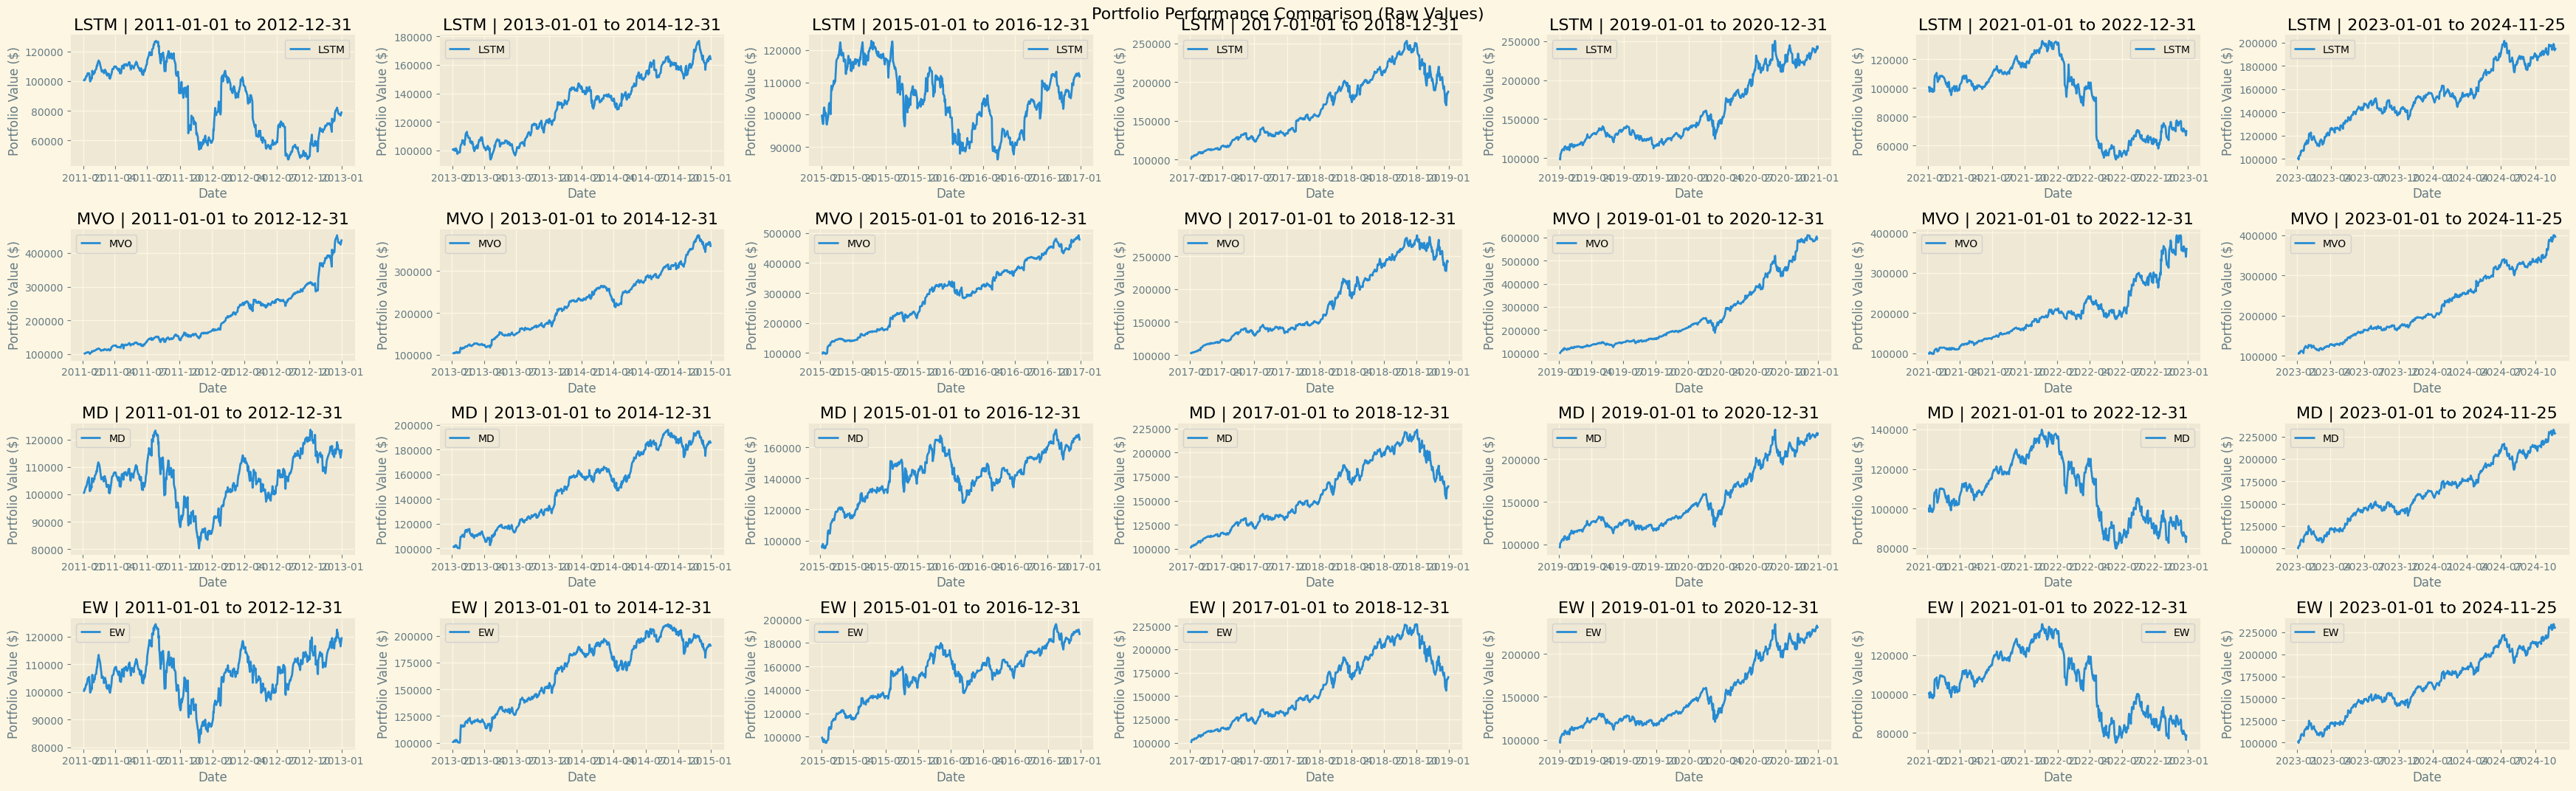

Period 1
LSTM Metrics:
Annualized Return: -0.1246
Annualized Std Dev: 0.5885
Sharpe Ratio: 0.0810
Sortino Ratio: 0.0971
Max Drawdown: 0.6286
% Positive Returns: 49.8000
Profit/Loss Ratio: 1.0253
MVO Metrics:
Annualized Return: 1.0691
Annualized Std Dev: 0.3294
Sharpe Ratio: 2.3703
Sortino Ratio: 3.7756
Max Drawdown: 0.1137
% Positive Returns: 57.1142
Profit/Loss Ratio: 1.1809
MD Metrics:
Annualized Return: 0.0643
Annualized Std Dev: 0.2573
Sharpe Ratio: 0.3691
Sortino Ratio: 0.5034
Max Drawdown: 0.3489
% Positive Returns: 54.5090
Profit/Loss Ratio: 0.8893
EW Metrics:
Annualized Return: 0.0798
Annualized Std Dev: 0.2824
Sharpe Ratio: 0.4118
Sortino Ratio: 0.5649
Max Drawdown: 0.3448
% Positive Returns: 52.6000
Profit/Loss Ratio: 0.9679


Period 2
LSTM Metrics:
Annualized Return: 0.2853
Annualized Std Dev: 0.2109
Sharpe Ratio: 1.2945
Sortino Ratio: 1.8874
Max Drawdown: 0.1719
% Positive Returns: 54.5817
Profit/Loss Ratio: 1.0322
MVO Metrics:
Annualized Return: 0.8940
Annualized Std Dev: 

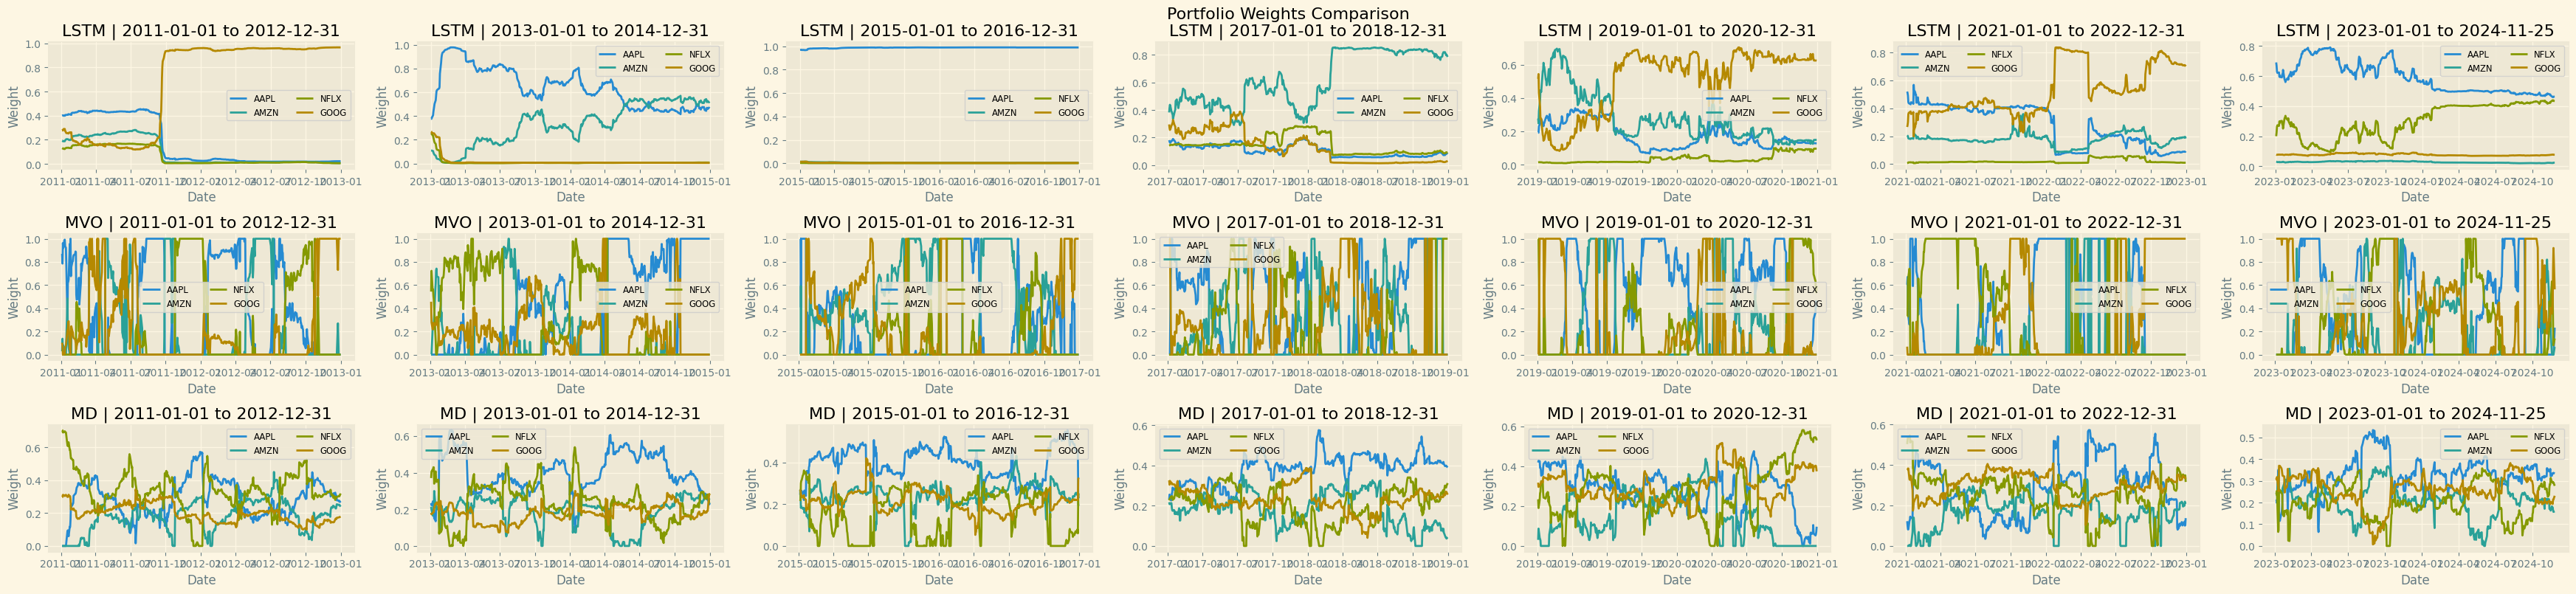

In [22]:
strategies = ['LSTM','MVO', 'MD', 'EW']
plot_performance_comparison(portfolio_histories, periods, strategies)
for i in range(len(mvo_metrics)):
    print(f"Period {i+1}")
    print("LSTM Metrics:")
    for key, value in lstm_metrics[i].items():
        print(f"{key}: {value:.4f}")
    print("MVO Metrics:")
    for key, value in mvo_metrics[i].items():
        print(f"{key}: {value:.4f}")
    print("MD Metrics:")
    for key, value in md_metrics[i].items():
        print(f"{key}: {value:.4f}")
    print("EW Metrics:")
    for key, value in ew_metrics[i].items():
        print(f"{key}: {value:.4f}")
    print("\n")
    strategies = ['LSTM','MVO', 'MD']
asset_names = TICKERS
plot_weights_comparison(portfolio_histories, periods, strategies, asset_names)